# Task 1

## Linear regression 

## Import all required libraries

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns              
import matplotlib.pyplot as plt  
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression,SGDRegressor, Lasso, Ridge
from sklearn.model_selection import GridSearchCV

## 1.Load Data

In [26]:
# Load the dataset (in Pandas DataFrame)
data = pd.read_csv('California_Houses.csv')
# Show dimensions of loaded data to make sure that data are fully loaded
print("data shape:", data.shape)
# Show First 5 Examples
data.head(5)

data shape: (20640, 14)


,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568


## 2.Visualize Realtionship between each feature and target (price)

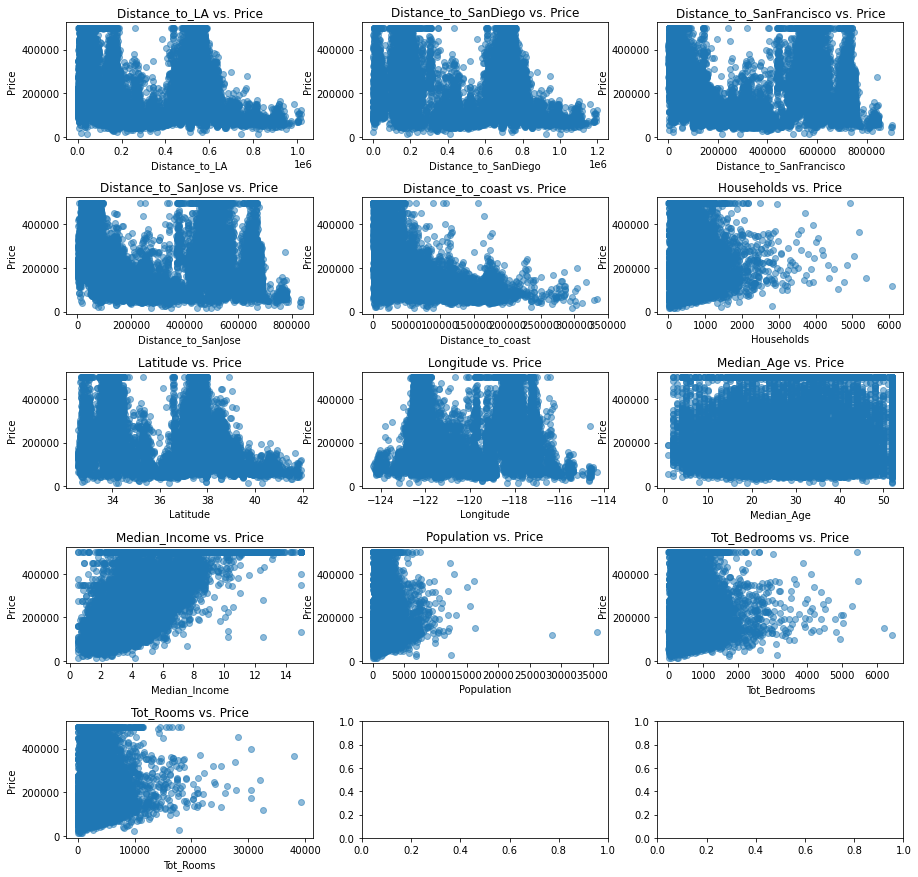

In [27]:
# Extract feature names from the DataFrame (excluding 'Median_House_Value')
features = data.columns.difference(['Median_House_Value'])

# Create basic scatter plots to visualize relationships
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    axes[row, col].scatter(data[feature], data['Median_House_Value'], alpha=0.5)
    axes[row, col].set_title(f'{feature} vs. Price')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Price')

plt.show()

## 3.Data Preprocessing

### Identify The Skewed Features

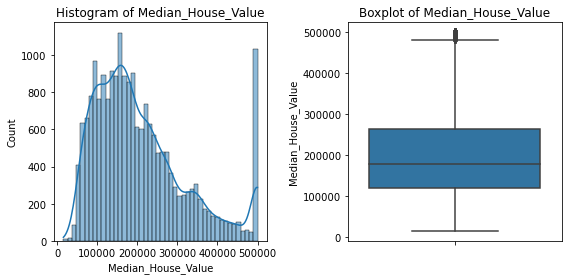

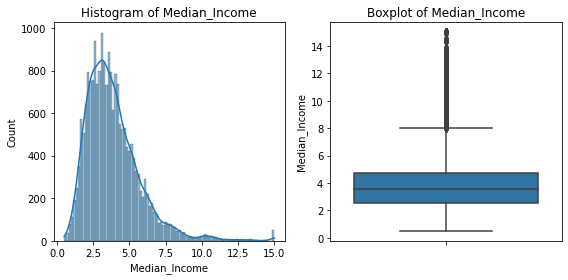

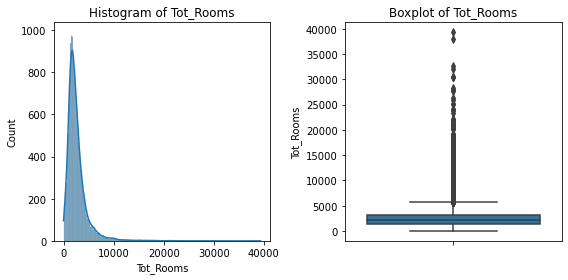

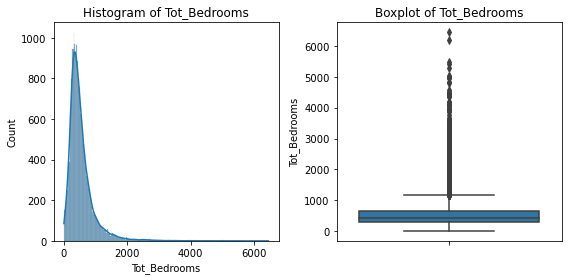

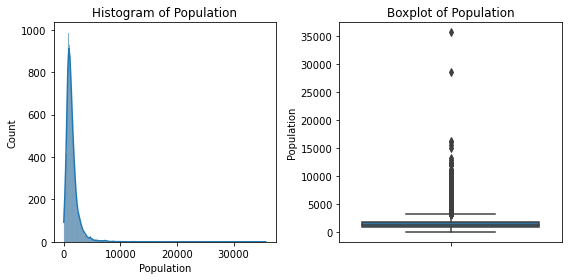

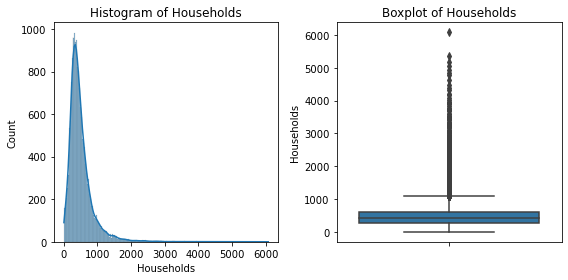

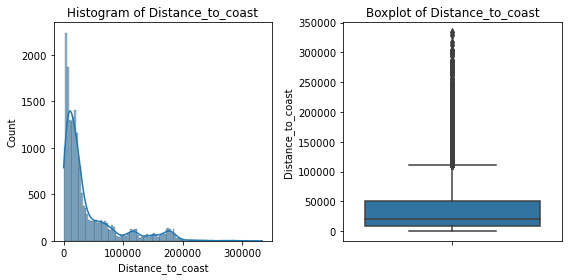

In [28]:
# Calculate skewness for all numeric features
numeric_features = data.select_dtypes(include=[np.number])
skewness = numeric_features.apply(lambda x: stats.skew(x))

# Assume threshold = 1/2
skew_threshold = 0.5

# Filter features with skewness above the threshold
skewed_features = skewness[abs(skewness) > skew_threshold]

# Create a histogram and boxplot for each skewed feature
for feature in skewed_features.index:
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=data[feature])
    plt.title(f'Boxplot of {feature}')  
    
    plt.tight_layout()
    plt.show()


### Apply Log to this skewed data (to enhance it)

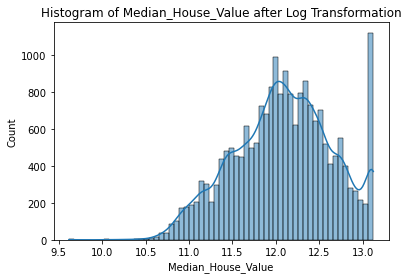

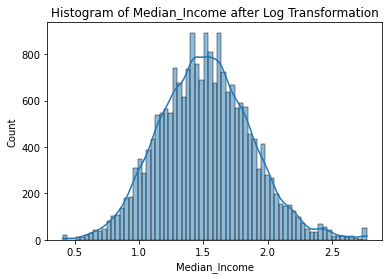

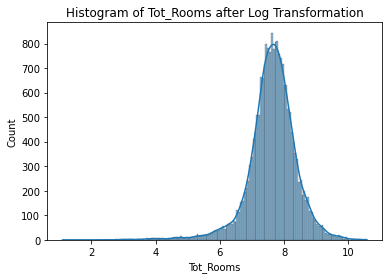

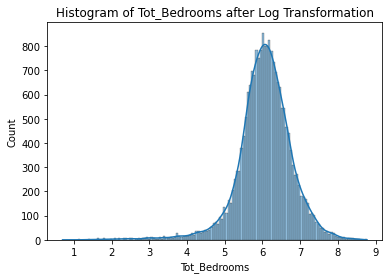

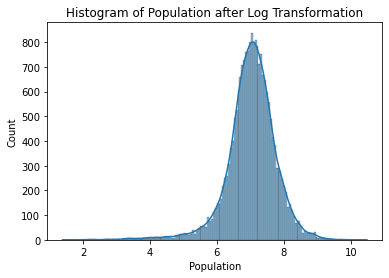

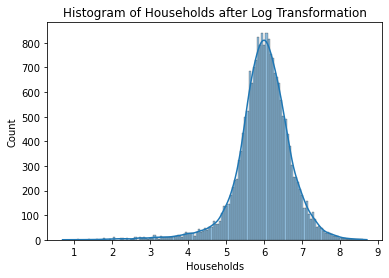

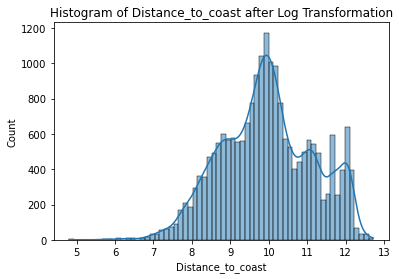

In [29]:
# Apply log transformation to skewed features
for feature in skewed_features.index:
    data[feature] = np.log1p(data[feature])

# Create histograms for each transformed feature
for feature in skewed_features.index:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Histogram of {feature} after Log Transformation')
    plt.show()

## Handling Outliers

In [30]:
# Calculate the IQR for each numeric feature
Q1 = data[numeric_features.columns].quantile(0.25)
Q3 = data[numeric_features.columns].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers using the IQR method
outliers = (data[numeric_features.columns] < (Q1 - 1.5 * IQR)) | (data[numeric_features.columns] > (Q3 + 1.5 * IQR))

# Remove outliers from the dataset
data = data[~outliers.any(axis=1)]

# Show dimensions of the cleaned data
print("Cleaned data shape:", data.shape)

# Show the cleaned data
data.head()

Cleaned data shape: (19191, 14)


,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,13.022766,2.232720,41,6.781058,4.867534,5.777652,4.844187,37.88,-122.23,9.133896,556529.158342,735501.806984,67432.517001,21250.213767
1,12.789687,2.230165,21,8.867850,7.009409,7.784057,7.037906,37.86,-122.22,9.232760,554279.850069,733236.884360,65049.908574,20880.600400
2,12.771673,2.111110,52,7.291656,5.252273,6.208590,5.181784,37.85,-122.24,9.019190,554610.717069,733525.682937,64867.289833,18811.487450
3,12.740520,1.893579,52,7.150701,5.463832,6.326149,5.393628,37.85,-122.25,8.957908,555194.266086,734095.290744,65287.138412,18031.047568
4,12.743154,1.578195,52,7.395108,5.638355,6.338594,5.560682,37.85,-122.25,8.957908,555194.266086,734095.290744,65287.138412,18031.047568


### Handling Missing Values

In [31]:
# Check for missing values in the features
missing_values = data.isnull().sum()
print("Missing Values in Features:")
print(missing_values)
#NO MISSING Values!

Missing Values in Features:
Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64


## 5.Split the data into training (70%), validation (15%), and testing (15%)

In [32]:
# Split the data into features (X) and target variable (y)
X = data.drop(columns=['Median_House_Value'])
y = data['Median_House_Value']

# Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (13433, 13) (13433,)
Validation set shape: (2879, 13) (2879,)
Test set shape: (2879, 13) (2879,)


### Z-Score Normalization

In [33]:
# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train_scaled = scaler.fit_transform(X_train)
# Transform the validation and test data using the same scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=data.columns.difference(['Median_House_Value']))
X_val = pd.DataFrame(X_val_scaled, columns=data.columns.difference(['Median_House_Value']))
X_test = pd.DataFrame(X_test_scaled, columns=data.columns.difference(['Median_House_Value']))

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (13433, 13) (13433,)
Validation set shape: (2879, 13) (2879,)
Test set shape: (2879, 13) (2879,)


In [34]:
# Check first 5 rows
X_train.head()

,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanFrancisco,Distance_to_SanJose,Distance_to_coast,Households,Latitude,Longitude,Median_Age,Median_Income,Population,Tot_Bedrooms,Tot_Rooms
0,-0.189833,-0.793694,0.864119,0.699780,1.018657,0.688244,-1.065263,1.241756,0.433025,-0.560603,-1.128806,1.251138,1.209054
1,-0.706092,1.865926,-0.476205,-0.281005,0.037388,-0.311174,0.984965,-1.410354,-2.002118,1.151072,1.155990,-1.303946,-1.527580
2,0.199150,0.173441,-0.341126,-0.654457,-0.997439,-0.763949,1.307211,-1.550201,0.347987,1.446105,1.411168,-0.951698,-1.231016
3,-1.383508,-1.196667,-0.984742,-0.806317,-0.189614,-0.770614,0.209708,0.013095,1.626801,-0.056129,0.122184,-0.452130,-0.275294
4,1.720856,0.737602,0.317293,0.277410,-0.578186,0.217514,-0.714996,0.602453,-0.256098,-1.029938,-0.715153,0.601392,0.644905


## 4.Apply Linear regression

In [39]:
# Initialize the model
linear_regressor = LinearRegression()

# Fit the model to the training data
linear_regressor.fit(X_train, y_train)

# Make predictions on the validation set
linear_regressor_prediction = linear_regressor.predict(X_val)

# Make predictions on the test data
y_test_pred_lr = linear_regressor.predict(X_test)

# Calculate and print mean squared error and mean absolute error 
linear_mse = mean_squared_error(y_val, linear_regressor_prediction)
linear_mae = mean_absolute_error(y_val, linear_regressor_prediction)
print("Mean Squared Error Of Linear Regression =", linear_mse*100,"%")
print("Mean Absolute Error Of Linear Regression =", linear_mae*100,"%")


# Calculate the R-squared score for the linear regression model
r2_val_lr = r2_score(y_val, linear_regressor_prediction)
r2_test_lr = r2_score(y_test, y_test_pred_lr)
print("R-squared score Of Linear Regression on validation set =", linear_mse)
print("R-squared score Of Linear Regression on test set =", linear_mae)

Mean Squared Error Of Linear Regression = 8.807972119437567 %
Mean Absolute Error Of Linear Regression = 22.42380766762378 %
R-squared score Of Linear Regression on validation set = 0.08807972119437567
R-squared score Of Linear Regression on test set = 0.2242380766762378


# EXTRA:

## Using Stochastic Gradient descent

In [43]:
# Create an SGDRegressor model with gradient descent optimizer
model_sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)

# Train the SGDRegressor model
model_sgd.fit(X_train, y_train)

# Make predictions on the validation and test data using SGDRegressor
y_val_pred_sgd = model_sgd.predict(X_val)
y_test_pred_sgd = model_sgd.predict(X_test)

# Calculate the mean squared error and R-squared score for the SGDRegressor model
mse_val_sgd = mean_squared_error(y_val, y_val_pred_sgd)
r2_val_sgd = r2_score(y_val, y_val_pred_sgd)
mse_test_sgd = mean_squared_error(y_test, y_test_pred_sgd)
r2_test_sgd = r2_score(y_test, y_test_pred_sgd)

print("Validation Set - Mean Squared Error:", mse_val_sgd*100,"%")
print("Test Set - Mean Squared Error:", mse_test_sgd*100,"%")
print("Validation Set - R-squared Score:", r2_val_sgd)
print("Test Set - R-squared Score:", r2_test_sgd)

Validation Set - Mean Squared Error: 8.830307081640978 %
Test Set - Mean Squared Error: 8.440625265545528 %
Validation Set - R-squared Score: 0.7171860786205493
Test Set - R-squared Score: 0.7236345575789724


## Apply Lasso Regression

In [12]:
# Define hyperparameter grids for Lasso 
lasso_param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV with the respective regressors and parameter grids
lasso_regressor = GridSearchCV(Lasso(max_iter=10000), lasso_param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grids to the training data
lasso_regressor.fit(X_train, y_train)

# Get the best hyperparameters for Lasso
best_lasso = lasso_regressor.best_estimator_

# Now, retrain the Lasso regressor with the best hyperparameters
best_lasso.fit(X_train, y_train)
print(best_lasso)

# Make predictions on the validation set using the best Lasso model
lasso_regressor_prediction = best_lasso.predict(X_val)

# Calculate and print mean squared error and mean absolute error for the best Lasso model
lasso_mse = mean_squared_error(y_val, lasso_regressor_prediction)
lasso_mae = mean_absolute_error(y_val, lasso_regressor_prediction)
print("Mean Squared Error Of Best Lasso Regression =", lasso_mse)
print("Mean Absolute Error Of Best Lasso Regression =", lasso_mae)

Lasso(alpha=0.0001, max_iter=10000)
Mean Squared Error Of Best Lasso Regression = 0.10127881291265355
Mean Absolute Error Of Best Lasso Regression = 0.23395521147021486


## Apply Ridge Regression

In [20]:
# Define hyperparameter grids for Ridge
ridge_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize GridSearchCV with the respective regressors and parameter grids
ridge_regressor = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grids to the training data
ridge_regressor.fit(X_train, y_train)

# Get the best hyperparameters for Ridge
best_ridge = ridge_regressor.best_estimator_

# Make predictions on the validation set using the best Ridge model
ridge_regressor_prediction = best_ridge.predict(X_val)

# Calculate and print mean squared error and mean absolute
ridge_mse = mean_squared_error(y_val, ridge_regressor_prediction)
ridge_mae = mean_absolute_error(y_val, ridge_regressor_prediction)
print("Mean Squared Error Of Ridge Regression =", ridge_mse)
print("Mean Absolute Error Of Ridge Regression =", ridge_mae)

Mean Squared Error Of Ridge Regression = 0.10130438141390889
Mean Absolute Error Of Ridge Regression = 0.23393495832967653


## Plot Performance

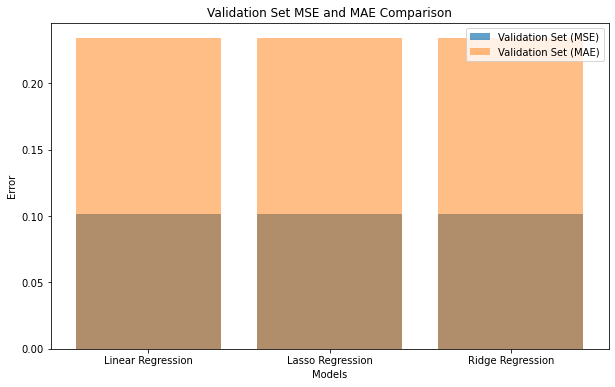

In [14]:
# Create a list of model names
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression']

# Create lists of MSE and MAE for validation set only
mse_validation = [linear_mse, lasso_mse, ridge_mse]
mae_validation = [linear_mae, lasso_mae, ridge_mae]

# Plot the MSE and MAE for validation set only
plt.figure(figsize=(10, 6))
plt.bar(models, mse_validation, label='Validation Set (MSE)', alpha=0.7)
plt.bar(models, mae_validation, label='Validation Set (MAE)', alpha=0.5)
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Validation Set MSE and MAE Comparison')
plt.legend()
plt.show()

## Compute MSE and MAE for test set

In [15]:
# Calculate mean squared error and mean absolute error for linear regression (test set)
linear_regressor_prediction = linear_regressor.predict(X_test)
linear_mse_test = mean_squared_error(y_test, linear_regressor_prediction)
linear_mae_test = mean_absolute_error(y_test, linear_regressor_prediction)
print("Mean Squared Error Of Linear Regression =", linear_mse_test)
print("Mean Absolute Error Of Linear Regression =", linear_mae_test)

Mean Squared Error Of Linear Regression = 0.09071771379333025
Mean Absolute Error Of Linear Regression = 0.2276109916345666


In [16]:
# Calculate mean squared error and mean absolute error for lasso resgression (test set)
lasso_regressor_prediction = lasso_regressor.predict(X_test)
lasso_mse_test = mean_squared_error(y_test, lasso_regressor_prediction)
lasso_mae_test = mean_absolute_error(y_test, lasso_regressor_prediction)
print("Mean Squared Error Of Lasso Regression =", lasso_mse_test)
print("Mean Absolute Error Of Lasso Regression =", lasso_mae_test)

Mean Squared Error Of Lasso Regression = 0.0907038110654024
Mean Absolute Error Of Lasso Regression = 0.2276920114604557


In [17]:
# Calculate mean squared error and mean absolute for ridge regression (test set)
ridge_regressor_prediction = ridge_regressor.predict(X_test)
ridge_mse_test = mean_squared_error(y_test, ridge_regressor_prediction)
ridge_mae_test = mean_absolute_error(y_test, ridge_regressor_prediction)
print("Mean Squared Error Of Ridge Regression =", ridge_mse_test)
print("Mean Absolute Error Of Ridge Regression =", ridge_mae_test)

Mean Squared Error Of Ridge Regression = 0.09071697131615189
Mean Absolute Error Of Ridge Regression = 0.22761328573626052


## Residual Plot before and after testing

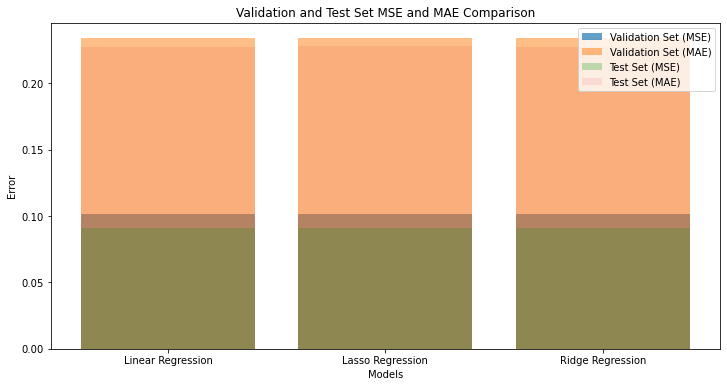

In [18]:
# Create a list of model names
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression']

# Create lists of MSE and MAE for validation set
mse_validation = [linear_mse, lasso_mse, ridge_mse]
mae_validation = [linear_mae, lasso_mae, ridge_mae]

# Create lists of MSE and MAE for the test set
mse_test = [linear_mse_test, lasso_mse_test, ridge_mse_test]
mae_test = [linear_mae_test, lasso_mae_test, ridge_mae_test]

# Plot the MSE and MAE for validation and test sets
plt.figure(figsize=(12, 6))

plt.bar(models, mse_validation, label='Validation Set (MSE)', alpha=0.7)
plt.bar(models, mae_validation, label='Validation Set (MAE)', alpha=0.5)
plt.bar(models, mse_test, label='Test Set (MSE)', alpha=0.3)
plt.bar(models, mae_test, label='Test Set (MAE)', alpha=0.1)

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Validation and Test Set MSE and MAE Comparison')
plt.legend()
plt.show()